In [1]:
import azureml.core
import logging

print("SDK version:", azureml.core.VERSION)

from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics=True)

import os
subscription_id = os.getenv("SUBSCRIPTION_ID", default="52f3cf55-fed4-4f7e-9aca-f3da535a03c1")
resource_group = os.getenv("RESOURCE_GROUP", default="automl_rg")
workspace_name = os.getenv("WORKSPACE_NAME", default="automl_ws")
workspace_region = os.getenv("WORKSPACE_REGION", default="eastus2")


from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication

try:
    interactive_auth = InteractiveLoginAuthentication(tenant_id="1591aa04-9c2a-4144-9a04-fb8b0d506de5")
    ws = Workspace(subscription_id = subscription_id, 
               resource_group = resource_group, 
               workspace_name = workspace_name,
               auth=interactive_auth)    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config()
    print("Workspace configuration succeeded.")
except:
    print("Workspace not accessible.")



SDK version: 1.0.45
Turning diagnostics collection on. 
Workspace configuration succeeded.


In [2]:
dataset_exp = {"defect_camel_1_2":"AutoML_29aecac8-d329-4ead-85e9-55db459752a2"
,"defect_eclipse_2_0":"AutoML_b89e58d1-6878-49b4-9c20-93c9b96cb05b"
,"defect_eclipse_3_0":"AutoML_d551db36-cd0d-4c80-8931-7c3912d47cb2"
,"defect_prop_2":"AutoML_5072b529-0b82-4718-9e82-343bd6bf8aac"
,"defect_xalan_2_6":"AutoML_561e7b85-1240-4bcc-aff3-5c674497ae0a"}

exp_runid = {"defect_camel_1_2":"Automl_defect_camel_1_2"
,"defect_eclipse_2_0":"Automl_defect_eclipse_2_0"
,"defect_eclipse_3_0":"Automl_defect_eclipse_3_0"
,"defect_prop_2":"Automl_defect_prop_2"
,"defect_xalan_2_6":"Automl_defect_xalan_2_6"}



In [166]:
def calProcessTime(remote_run):
    from dateutil import parser
    delta = parser.parse(remote_run.get_details()['endTimeUtc'])- parser.parse(remote_run.get_details()['startTimeUtc'])
    return delta.seconds/3600


def calElapseTime(remote_run,initalCreateTime):
    from dateutil import parser
    delta = parser.parse(remote_run.get_details()['startTimeUtc'])- parser.parse(initalCreateTime)
    return delta.seconds/3600

In [146]:
from azureml.widgets import RunDetails
from azureml.train.automl.run import AutoMLRun
from azureml.core.experiment import Experiment
a_allrun_map={}
for dataset,exp in exp_runid.items():
    experiment=Experiment(ws, exp)
    remote_run = AutoMLRun(experiment = experiment, run_id =dataset_exp[dataset])
    a_allrun_map[dataset]=remote_run
 

In [187]:
a_performance_tb={}
a_all_metrics={}
for dataset,remote_run in a_allrun_map.items():
    totalProcessTime = round(calProcessTime(remote_run),2)
    expCreateTime = remote_run.get_details()['startTimeUtc']

    children = list(remote_run.get_children())
    a_metrics = {}
    for run in children:
        if run.status=='Running':
            continue
        prop    =  run.get_properties()
        iterationNum = int(prop['iteration'])
        if iterationNum > 100: iterationNum = 200 - iterationNum
        #print(iterationNum)
        algo = prop['run_algorithm']
        auc_w = prop['score']
        durationT = calProcessTime(run)
        PriorElapseTime = calElapseTime(run,expCreateTime)
        a_metrics[iterationNum] = {'Algorithm':algo,'AUC_weighted':str(round(float(auc_w),6))
                                   ,'Iteration':iterationNum
                                   ,'TrainTime':str(round(durationT,3))
                                   ,'PriorElapseTime':str(round(PriorElapseTime,3))
                                  }
   
    sorted_performance_index =sorted(a_metrics, key =  lambda kv:a_metrics[kv]['AUC_weighted'],reverse=True)
    top3 = sorted_performance_index[0:3]
    a_all_metrics[dataset]=a_metrics
    import pandas as pd
    tb = []
    for index in top3:
        row = a_metrics[index]
        #row['Iteration']=index
        tb.append(row)

    df = pd.DataFrame(tb, index = ['Rank 1','Rank 2','Rank 3'])
    #df.columns=['Iteration', 'Algorithm','AUC_weighted','TrainTime','PriorElapseTime']
    a_performance_tb[dataset]=df
    print('AutoML: '+dataset+'\n')
    #print(df)
    #print('\n')

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code EVHLUBHJR to authenticate.
Interactive authentication successfully completed.
AutoML: defect_camel_1_2

AutoML: defect_eclipse_2_0

AutoML: defect_eclipse_3_0

AutoML: defect_prop_2

AutoML: defect_xalan_2_6



In [184]:
from IPython.display import display, HTML
for dataset in a_performance_tb.keys():
    df=a_performance_tb[dataset]
    print('AutoML: '+dataset)
    #print(df)
    display(df)
    print('\n')

AutoML: defect_camel_1_2


,AUC_weighted,Algorithm,Iteration,PriorElapseTime,TrainTime
Rank 1,0.630715,ExtremeRandomTrees,29,0.242,0.016
Rank 2,0.629801,ExtremeRandomTrees,20,0.121,0.045
Rank 3,0.629184,ExtremeRandomTrees,30,0.261,0.01




AutoML: defect_eclipse_2_0


,AUC_weighted,Algorithm,Iteration,PriorElapseTime,TrainTime
Rank 1,0.83084,LightGBM,31,0.45,0.019
Rank 2,0.830132,LightGBM,85,1.779,0.005
Rank 3,0.829923,ExtremeRandomTrees,32,0.475,0.015




AutoML: defect_eclipse_3_0


,AUC_weighted,Algorithm,Iteration,PriorElapseTime,TrainTime
Rank 1,0.808516,LightGBM,61,1.55,0.02
Rank 2,0.808213,LightGBM,68,1.703,0.006
Rank 3,0.808095,GradientBoosting,28,0.526,0.12




AutoML: defect_prop_2


,AUC_weighted,Algorithm,Iteration,PriorElapseTime,TrainTime
Rank 1,0.828701,XGBoostClassifier,83,5.097,0.059
Rank 2,0.827398,XGBoostClassifier,63,3.562,0.05
Rank 3,0.826727,XGBoostClassifier,21,0.699,0.046




AutoML: defect_xalan_2_6


,AUC_weighted,Algorithm,Iteration,PriorElapseTime,TrainTime
Rank 1,0.828889,RandomForest,80,0.794,0.025
Rank 2,0.828358,RandomForest,64,0.564,0.007
Rank 3,0.823589,ExtremeRandomTrees,21,0.128,0.018


In [189]:
def extractElapseTime(iteration,all_metrics):
    return float(all_metrics[iteration]['TrainTime'])+float(all_metrics[iteration]['PriorElapseTime'])

In [207]:
from IPython.display import display, HTML
import pandas as pd
tb = []
for dataset in a_all_metrics.keys():
    all_metrics = a_all_metrics[dataset]
    printed_row = {}
    printed_row['Dataset']=dataset.split('defect_')[1]
    printed_row['1st'] = extractElapseTime(1,all_metrics)
    printed_row['5th'] = extractElapseTime(4,all_metrics)
    printed_row['10th'] = extractElapseTime(9,all_metrics)
    printed_row['20th'] = extractElapseTime(19,all_metrics)    
    printed_row['50th'] = extractElapseTime(49,all_metrics)    
    printed_row['100th'] = extractElapseTime(99,all_metrics)        
    #row['Iteration']=index
    tb.append(printed_row)

df = pd.DataFrame(tb)

df=df[['Dataset','1st','10th','20th','50th','100th']]
display(HTML(df.to_html(index=False)))
print('\n')

Dataset,1st,10th,20th,50th,100th
camel_1_2,0.01,0.05,0.12,0.50,1.07
eclipse_2_0,0.01,0.11,0.25,0.93,2.03
eclipse_3_0,0.02,0.14,0.33,1.23,2.55
prop_2,0.03,0.21,0.45,2.70,6.09
xalan_2_6,0.01,0.05,0.12,0.41,0.99


In [522]:
df.sort_values('AUC_weighted',ascending=False)

,Iteration,Elapse Time,AUC_weighted,Algorithm
19,81,47.60,0.828889,RandomForest
35,65,33.80,0.828358,RandomForest
78,22,7.70,0.823589,ExtremeRandomTrees
4,96,55.10,0.822766,RandomForest
91,9,2.50,0.822709,XGBoostClassifier
9,91,52.70,0.822017,RandomForest
94,6,1.60,0.821542,RandomForest
2,98,55.90,0.820978,XGBoostClassifier
34,66,34.40,0.820644,RandomForest
54,46,20.90,0.820382,ExtremeRandomTrees


In [529]:
    df_perf_max = df.sort_values('AUC_weighted',ascending=False).iloc[0] 

In [517]:
all_metrics = a_all_metrics[dataset]
df=pd.DataFrame({
    'Iteration':[x+1 for x in list(all_metrics.keys())],
    'Elapse Time':[ round(float(x['PriorElapseTime'])*60,1) for x in all_metrics.values()],
    'AUC_weighted':[ x['AUC_weighted'] for x in all_metrics.values()],
    'Algorithm': [ x['Algorithm'] for x in all_metrics.values()]
})

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 <a list of 9 Text yticklabel objects>)

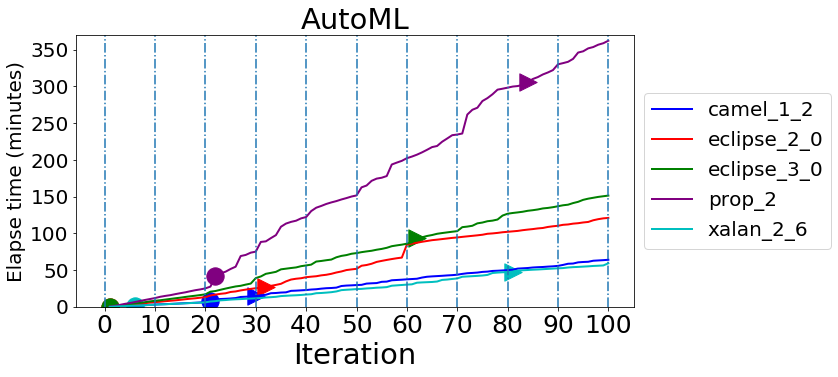

In [544]:

fig1, ax1 = plt.subplots()
ax1.set_title('AutoML',fontsize = 29)
plt.rcParams["figure.figsize"] = (10, 5)

axes = plt.gca()
axes.set_ylim([0,370])
colorlist = ['blue','r','g','purple','c']
color_idx=0
for dataset in a_all_metrics.keys():
    all_metrics = a_all_metrics[dataset]
    df=pd.DataFrame({
        'Iteration':[x+1 for x in list(all_metrics.keys())],
        'Elapse Time':[ round(float(x['PriorElapseTime'])*60,1) for x in all_metrics.values()],
        'AUC_weighted':[ str(x['AUC_weighted']) for x in all_metrics.values()],
        'Algorithm': [ x['Algorithm'] for x in all_metrics.values()]
    })
    df_perf_max = df.sort_values('AUC_weighted',ascending=False).iloc[0] 
    plt.plot( 'Iteration', 'Elapse Time', data=df, 
             #marker='o', markerfacecolor='blue', markersize=12, color='skyblue', 
             color = colorlist[color_idx],
             label = dataset.split('defect_')[1],
             linewidth=2)
    
    plt.scatter ( 'Iteration', 'Elapse Time', data=df_perf_max, 
             marker='>',  s=300,
                 #markerfacecolor='blue', color='skyblue', 
             color = colorlist[color_idx],
             label = '')

    best_performance = float(df_perf_max['AUC_weighted'])
    df['AUC percentage'] = [ float(x)/float(best_performance) for x in df['AUC_weighted']]
    df_perf_morethan_099 = df.loc[df['AUC percentage']>=0.99].sort_values('Iteration',ascending=True).iloc[0]

    plt.scatter ( 'Iteration', 'Elapse Time', data=df_perf_morethan_099, 
             marker='o',  s=300,
                 #markerfacecolor='blue', color='skyblue', 
             color = colorlist[color_idx],
             label = '')
    color_idx= color_idx+1
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 20})
xlabel ('Iteration',fontsize = 29)
ylabel ('Elapse time (minutes)',fontsize = 20)

#plt.axhline(y=threshold, color='r', linestyle='-.')
for vx in range(0,101,10):
    plt.axvline(x=vx,linestyle='-.')
        
plt.xticks(range(0,101,10),fontsize = 25)
plt.yticks(fontsize = 20)
#plt.axhline(y=threshold, color='r', linestyle='-.')


In [233]:
def calculateImprovement(iteration,all_metrics,bestPerformance):
    # return the absolute performance improvement
    return float(all_metrics[iteration]['AUC_weighted'])/bestPerformance

In [234]:
from IPython.display import display, HTML
import pandas as pd
tb = []
for dataset in a_all_metrics.keys():
    all_metrics = a_all_metrics[dataset]
    bestPerformance=float(a_performance_tb[dataset]['AUC_weighted'][0])

    printed_row = {}
    printed_row['Dataset']=dataset.split('defect_')[1]
    printed_row['1st'] =  calculateImprovement(1,all_metrics,bestPerformance)
    printed_row['5th'] =  calculateImprovement(4,all_metrics,bestPerformance)
    printed_row['10th'] = calculateImprovement(9,all_metrics,bestPerformance)
    printed_row['20th'] = calculateImprovement(19,all_metrics,bestPerformance)    
    printed_row['50th'] = calculateImprovement(49,all_metrics,bestPerformance)    
    printed_row['100th']= calculateImprovement(99,all_metrics,bestPerformance)        
    #row['Iteration']=index
    tb.append(printed_row)

df = pd.DataFrame(tb)

df=df[['Dataset','1st','10th','20th','50th','100th']]
display(HTML(df.to_html(index=False)))
print('\n')

Dataset,1st,10th,20th,50th,100th
camel_1_2,0.94,0.91,0.94,0.95,0.96
eclipse_2_0,0.98,0.99,0.95,0.99,0.98
eclipse_3_0,0.98,0.99,0.97,0.99,0.94
prop_2,0.95,0.98,0.98,0.98,0.98
xalan_2_6,0.99,0.98,0.99,0.98,0.99


In [235]:
display(HTML(df.T.to_html()))

,0,1,2,3,4
Dataset,camel_1_2,eclipse_2_0,eclipse_3_0,prop_2,xalan_2_6
1st,0.94,0.98,0.98,0.95,0.99
10th,0.91,0.99,0.99,0.98,0.98
20th,0.94,0.95,0.97,0.98,0.99
50th,0.95,0.99,0.99,0.98,0.98
100th,0.96,0.98,0.94,0.98,0.99


camel_1_2
0.9366639448879446
0.91164947718066
0.9373330268029141
0.9515676652687822
0.9610204291954368


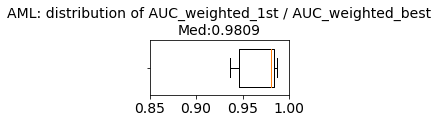

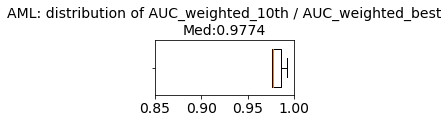

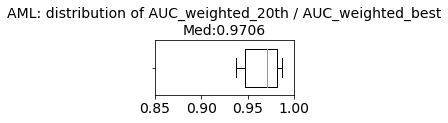

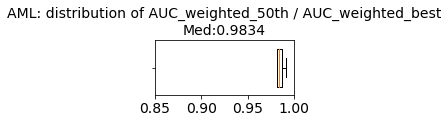

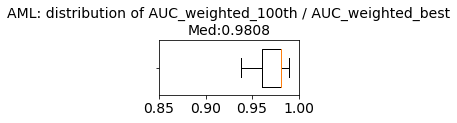

In [241]:

import matplotlib.pyplot as plt
from pylab import *
for row in df.T.iterrows() :
    print(row[1][0])
    if row[0]=='Dataset':
        continue
    auc_weighted_list = row[1]
    plt.rcParams["figure.figsize"] = (2.5, 1)
    fig1, ax1 = plt.subplots()
    title = 'AML: distribution of AUC_weighted_'+str(row[0]) +' / AUC_weighted_best'

    #print(title)
    bp_dict = ax1.boxplot(auc_weighted_list,vert=False,showfliers=False,widths = 0.7)
    plt.xticks(fontsize=14)
    ax1.set_xlim([0.85,1])
    ax1.set_yticklabels('')
    ax1.set_title(title+'\n'+'Med:' + str(round(median(auc_weighted_list),4)),fontsize = 14)

In [254]:
from IPython.display import display, HTML
import pandas as pd
groupedIterationMap ={}
for dataset in a_all_metrics.keys():
    all_metrics = a_all_metrics[dataset]
    bestPerformance=float(a_performance_tb[dataset]['AUC_weighted'][0])
    tb = []
    for ita in range(0,105,5):
        index = ita
        if index != 0:
            index = index -1
        printed_row = {}
        #printed_row['Dataset']=dataset.split('defect_')[1]
        printed_row['Iteration'] = index
        printed_row['POB'] = calculateImprovement(index,all_metrics,bestPerformance)
        tb.append(printed_row)
    groupedIterationMap[dataset.split('defect_')[1]] = tb

display(HTML(df.to_html(index=False)))
print('\n')

camel_1_2,eclipse_2_0,eclipse_3_0,prop_2,xalan_2_6
"{'Iteration': 0, 'POB': 0.9274601048016933}","{'Iteration': 0, 'POB': 0.9937966395455202}","{'Iteration': 0, 'POB': 0.9973296756032038}","{'Iteration': 0, 'POB': 0.9374780530010222}","{'Iteration': 0, 'POB': 0.9758363303168458}"
"{'Iteration': 4, 'POB': 0.8750069365719858}","{'Iteration': 4, 'POB': 0.9694297337634201}","{'Iteration': 4, 'POB': 0.9709999554739795}","{'Iteration': 4, 'POB': 0.8944287505384934}","{'Iteration': 4, 'POB': 0.9732533547917754}"
"{'Iteration': 9, 'POB': 0.91164947718066}","{'Iteration': 9, 'POB': 0.9860033219392422}","{'Iteration': 9, 'POB': 0.9927397849887942}","{'Iteration': 9, 'POB': 0.977388708351987}","{'Iteration': 9, 'POB': 0.9761620675385969}"
"{'Iteration': 14, 'POB': 0.9488009639853183}","{'Iteration': 14, 'POB': 0.9782894420104954}","{'Iteration': 14, 'POB': 0.9774166497632699}","{'Iteration': 14, 'POB': 0.8680151224627459}","{'Iteration': 14, 'POB': 0.9613711848027903}"
"{'Iteration': 19, 'POB': 0.9373330268029141}","{'Iteration': 19, 'POB': 0.9467779596552887}","{'Iteration': 19, 'POB': 0.9705831424486343}","{'Iteration': 19, 'POB': 0.9810715807028109}","{'Iteration': 19, 'POB': 0.9870320392718446}"
"{'Iteration': 24, 'POB': 0.9286444749213193}","{'Iteration': 24, 'POB': 0.9947835925087862}","{'Iteration': 24, 'POB': 0.9901201707820253}","{'Iteration': 24, 'POB': 0.987352495049481}","{'Iteration': 24, 'POB': 0.9776894131783629}"
"{'Iteration': 29, 'POB': 1.0}","{'Iteration': 29, 'POB': 0.9828354436473931}","{'Iteration': 29, 'POB': 0.9968163895334168}","{'Iteration': 29, 'POB': 0.9934487830954711}","{'Iteration': 29, 'POB': 0.9802760080058971}"
"{'Iteration': 34, 'POB': 0.9391214732486146}","{'Iteration': 34, 'POB': 0.9682165037793076}","{'Iteration': 34, 'POB': 0.9879235537701171}","{'Iteration': 34, 'POB': 0.9764173085346827}","{'Iteration': 34, 'POB': 0.9844756052981762}"
"{'Iteration': 39, 'POB': 0.9598011780281109}","{'Iteration': 39, 'POB': 0.9942660440036589}","{'Iteration': 39, 'POB': 0.9918913169312666}","{'Iteration': 39, 'POB': 0.9871594217938677}","{'Iteration': 39, 'POB': 0.9867364629039594}"
"{'Iteration': 44, 'POB': 0.9597456854522248}","{'Iteration': 44, 'POB': 0.9825850946030522}","{'Iteration': 44, 'POB': 0.9897812782925756}","{'Iteration': 44, 'POB': 0.9719090480161119}","{'Iteration': 44, 'POB': 0.979331370062819}"


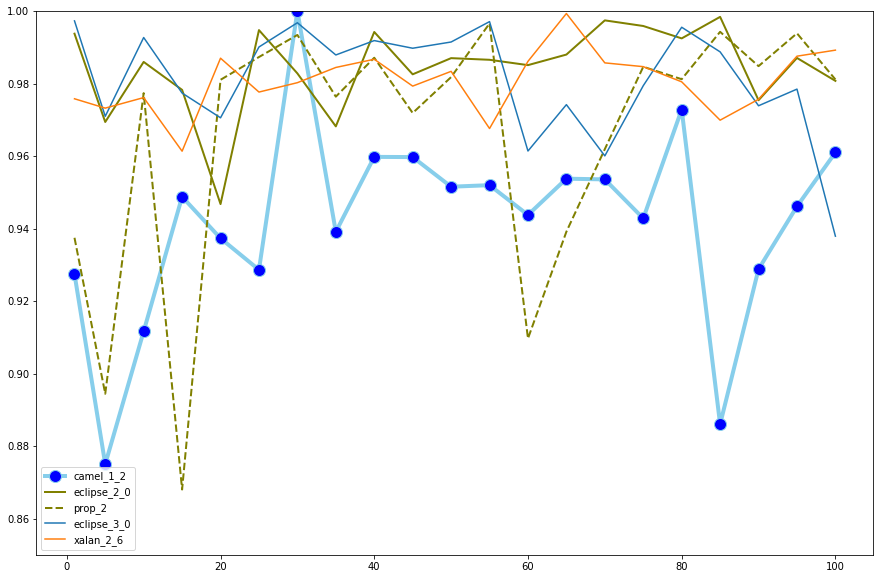

In [286]:

df=pd.DataFrame({'Iteration': [x['Iteration']+1 for x in groupedIterationMap['eclipse_2_0']]
                 ,'eclipse_2_0': [x['POB'] for x in groupedIterationMap['eclipse_2_0']]
                 , 'eclipse_3_0':  [x['POB'] for x in groupedIterationMap['eclipse_3_0']]
                 , 'camel_1_2':  [x['POB'] for x in groupedIterationMap['camel_1_2']]
                 , 'prop_2':  [x['POB'] for x in groupedIterationMap['prop_2']]
                 , 'xalan_2_6':  [x['POB'] for x in groupedIterationMap['xalan_2_6']]
                }
               )

plt.rcParams["figure.figsize"] = (15, 10)
axes = plt.gca()
axes.set_ylim([0.85,1])
plt.plot( 'Iteration', 'camel_1_2', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'Iteration', 'eclipse_2_0', data=df, marker='', color='olive', linewidth=2)
plt.plot( 'Iteration', 'prop_2', data=df, marker='', color='olive', linewidth=2, linestyle='dashed')
plt.plot( 'Iteration', 'eclipse_3_0', data=df, marker='')
plt.plot( 'Iteration', 'xalan_2_6', data=df, marker='')
plt.legend()


In [287]:
from IPython.display import display, HTML
import pandas as pd
groupedIterationMap ={}
for dataset in a_all_metrics.keys():
    all_metrics = a_all_metrics[dataset]
    bestPerformance=float(a_performance_tb[dataset]['AUC_weighted'][0])
    tb = []
    for ita in range(0,100):
        index = ita
        if index != 0:
            index = index -1
        printed_row = {}
        #printed_row['Dataset']=dataset.split('defect_')[1]
        printed_row['Iteration'] = index
        printed_row['POB'] = calculateImprovement(index,all_metrics,bestPerformance)
        tb.append(printed_row)
    groupedIterationMap[dataset.split('defect_')[1]] = tb

display(HTML(df.to_html(index=False)))
print('\n')

Iteration,eclipse_2_0,eclipse_3_0,camel_1_2,prop_2,xalan_2_6
1,0.99,1.00,0.93,0.94,0.98
5,0.97,0.97,0.88,0.89,0.97
10,0.99,0.99,0.91,0.98,0.98
15,0.98,0.98,0.95,0.87,0.96
20,0.95,0.97,0.94,0.98,0.99
25,0.99,0.99,0.93,0.99,0.98
30,0.98,1.00,1.00,0.99,0.98
35,0.97,0.99,0.94,0.98,0.98
40,0.99,0.99,0.96,0.99,0.99
45,0.98,0.99,0.96,0.97,0.98


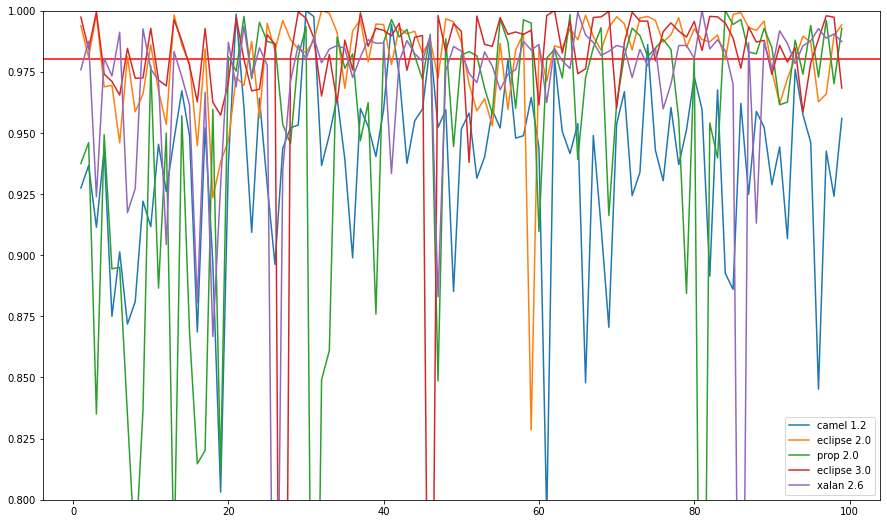

In [305]:

df=pd.DataFrame({'Iteration': [x['Iteration']+1 for x in groupedIterationMap['eclipse_2_0']]
                 ,'eclipse_2_0': [x['POB'] for x in groupedIterationMap['eclipse_2_0']]
                 , 'eclipse_3_0':  [x['POB'] for x in groupedIterationMap['eclipse_3_0']]
                 , 'camel_1_2':  [x['POB'] for x in groupedIterationMap['camel_1_2']]
                 , 'prop_2':  [x['POB'] for x in groupedIterationMap['prop_2']]
                 , 'xalan_2_6':  [x['POB'] for x in groupedIterationMap['xalan_2_6']]
                }
               )

plt.rcParams["figure.figsize"] = (15, 9)
axes = plt.gca()
axes.set_ylim([0.8,1])
plt.axhline(y=0.98, color='r', linestyle='-')

threshold = 0.99
plt.plot( 'Iteration', 'camel_1_2', data=df ,label = 'camel 1.2')
plt.plot( 'Iteration', 'eclipse_2_0', data=df,label = 'eclipse 2.0')
plt.plot( 'Iteration', 'prop_2', data=df,label = 'prop 2.0')
plt.plot( 'Iteration', 'eclipse_3_0', data=df,label = 'eclipse 3.0')
plt.plot( 'Iteration', 'xalan_2_6', data=df,label = 'xalan 2.6')
plt.legend()


Text(0, 0.5, 'AW_ite / AW_best\n(AW: AUC_weighted)')

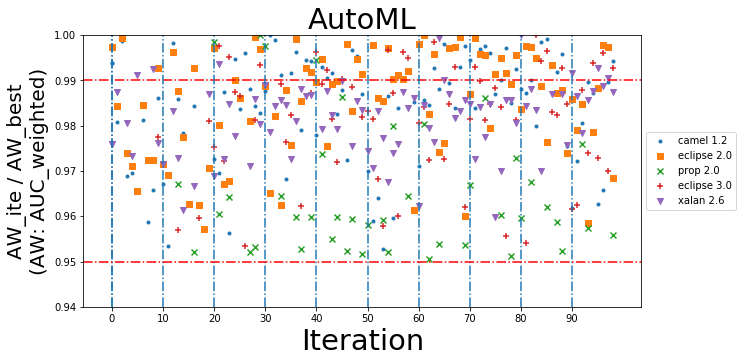

In [364]:

df_eclipse_2_0=pd.DataFrame(groupedIterationMap['eclipse_2_0'])
df_eclipse_3_0= pd.DataFrame(groupedIterationMap['eclipse_3_0'])
df_camel_1_2= pd.DataFrame(groupedIterationMap['camel_1_2'])
df_prop_2= pd.DataFrame( groupedIterationMap['prop_2'])
df_xalan_2_6= pd.DataFrame(groupedIterationMap['xalan_2_6'])

fig1, ax1 = plt.subplots()
ax1.set_title('AutoML',fontsize = 29)
plt.rcParams["figure.figsize"] = (10, 5)
axes = plt.gca()
axes.set_ylim([0.94,1])
threshold = 0.99
plt.axhline(y=threshold, color='r', linestyle='-.')
for vx in df_eclipse_2_0['Iteration']:
    if vx % 10 ==0:
        plt.axvline(x=vx,linestyle='-.')
#text(0.00, threshold, str(threshold), fontsize=25) # draw above, centered
plt.xticks(range(0,100,10))

threshold = 0.95
plt.axhline(y=threshold, color='r', linestyle='-.')
markers=['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']
plt.scatter( 'Iteration', 'POB', data=df_eclipse_2_0.loc[df_eclipse_2_0['POB']>=threshold],label = 'camel 1.2',marker=markers[1])
plt.scatter( 'Iteration', 'POB', data=df_eclipse_3_0.loc[df_eclipse_3_0['POB']>=threshold],label = 'eclipse 2.0',marker=markers[2])
plt.scatter( 'Iteration', 'POB', data=df_camel_1_2.loc[df_camel_1_2['POB']>=threshold],label = 'prop 2.0',marker=markers[3])
plt.scatter( 'Iteration', 'POB', data=df_prop_2.loc[df_prop_2['POB']>=threshold],label = 'eclipse 3.0',marker=markers[4])
plt.scatter( 'Iteration', 'POB', data=df_xalan_2_6.loc[df_xalan_2_6['POB']>=threshold],label = 'xalan 2.6',marker=markers[5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
xlabel ('Iteration',fontsize = 29)
ylabel ('AW_ite / AW_best\n(AW: AUC_weighted)',fontsize = 20)


In [477]:
def pltSetting(plt,df,label,thresholdhigh,thresholdlow):
    
    axes = plt.gca()
    axes.set_ylim([0.94,1])
    plt.yticks([0.95,0.99,1],fontsize = 12)
    markers=['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']
    plt.scatter( 'Iteration', 'POB', data=df.loc[df['POB']>=thresholdhigh],color = 'r',label = label,marker='+',s=30)
    tmp = df.loc[df['POB']>=thresholdlow]
    plt.scatter( 'Iteration', 'POB', data=tmp.loc[tmp['POB']<thresholdhigh],color = 'b',label='',marker='+',s=30)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 15})
    leg = plt.gca().get_legend()
    leg.legendHandles[0].set_visible(False)
    plt.axhline(y=thresholdlow, color='g', linestyle='-.')
    plt.xticks([])
    plt.axhline(y=thresholdhigh, color='g', linestyle='-.')
    for vx in range(0,100,10):
        if vx ==0: 
            vx = vx
        plt.axvline(x=vx,linestyle='-.',color = 'g')
    return None

Text(0.5, 0, 'Iteration')

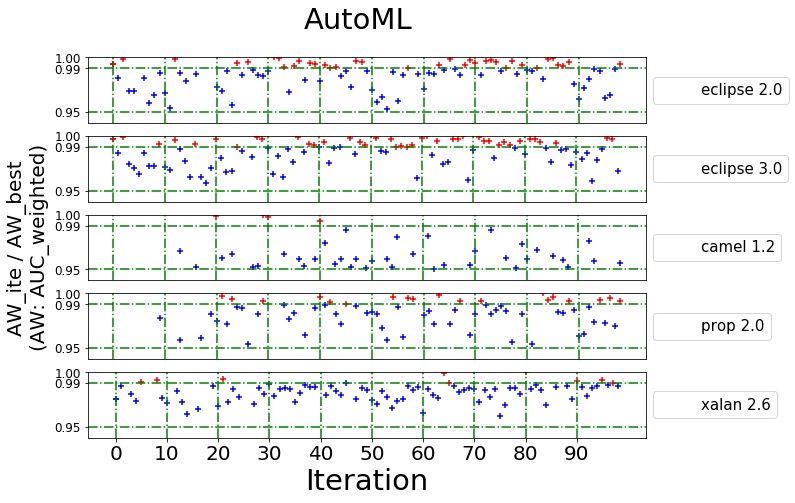

In [478]:
df_eclipse_2_0=pd.DataFrame(groupedIterationMap['eclipse_2_0'])
df_eclipse_3_0= pd.DataFrame(groupedIterationMap['eclipse_3_0'])
df_camel_1_2= pd.DataFrame(groupedIterationMap['camel_1_2'])
df_prop_2= pd.DataFrame( groupedIterationMap['prop_2'])
df_xalan_2_6= pd.DataFrame(groupedIterationMap['xalan_2_6'])

fig1, ax1 = plt.subplots()
fig1.suptitle('AutoML',fontsize = 29)
plt.rcParams["figure.figsize"] = (10, 7)

thresholdhigh = 0.99
thresholdlow = 0.95

plt.subplot(5,1,1)
pltSetting(plt,df_eclipse_2_0,'eclipse 2.0',thresholdhigh,thresholdlow)

plt.subplot(5,1,2)
pltSetting(plt,df_eclipse_3_0,'eclipse 3.0',thresholdhigh,thresholdlow)

plt.subplot(5,1,3)
pltSetting(plt,df_camel_1_2,'camel 1.2',thresholdhigh,thresholdlow)

ylabel ('AW_ite / AW_best\n(AW: AUC_weighted)',fontsize = 20)

plt.subplot(5,1,4)
pltSetting(plt,df_prop_2,'prop 2.0',thresholdhigh,thresholdlow)

plt.subplot(5,1,5)
pltSetting(plt,df_xalan_2_6,'xalan 2.6',thresholdhigh,thresholdlow)

plt.xticks(range(0,100,10),fontsize = 20)

xlabel ('Iteration',fontsize = 29)
